# Gathering Data: IMDB Movie Rating
This is a notebook of the case study done in this lesson. The aim of this case study is to help us pick a movie to watch based off movie rating websites like Rotten Tomatoes or IMDb. We'll be gathering data of different formats from different sources to help us put together a personalized top 100 lists based off reviews that are trusted. H'enjoy!

## Source: File on Hand 
The first source of data is a flat file given on hand to simulate data gotten from an email or from a thumbdrive or from my company's database. The dataset, [Rotten Tomatoes Top 100 Movies of All Time TSV File](https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ca594d_bestofrt/bestofrt.tsv), was manually downloaded.

In [1]:
import pandas as pd

In [2]:
# importing the rotten tomatoes 'bestofrt.tsv' tsv file into a dataframe
df = pd.read_csv('bestofrt.tsv', sep='\t')

In [3]:
df.head()

,ranking,critic_score,title,number_of_critic_ratings
0,1,99,The Wizard of Oz (1939),110
1,2,100,Citizen Kane (1941),75
2,3,100,The Third Man (1949),77
3,4,99,Get Out (2017),282
4,5,97,Mad Max: Fury Road (2015),370


## Source: Web Scraping
Next, we'll like to get Rotten Tomatoes' audience scores and the number of audience reviews to add to our dataset. Since this isn't easily available, **web scraping** to the rescue!

![webscraping](img/webscrapping.png)

Let's use `BeautifulSoup` to parse the downloaded HTML files of the Rotten Tomatoes webpages for our movies of interest using `lmxl` as our parser.

In [4]:
from bs4 import BeautifulSoup
import os

Let's extract the title, audience score, and the number of audience ratings in each HTML file into a dataframe.

In [5]:
# list of dictionaries to build file by file and later convert to a dataframe
df_list = []
folder = 'rt_html'

# iterating through each html file in the folder
for movie_html in os.listdir(folder):
      with open(os.path.join(folder, movie_html)) as file:
            # making the soup by passing the file into the Beautiful soup
            # constructor together with the parser, lxml
            soup = BeautifulSoup(file, 'lxml')
            title = soup.find('title').contents[0][:-len(' - Rotten Tomatoes')]
            # play with this to be able to re-understand it. 
            audience_score = soup.find('div', class_='audience-score meter').find('span').contents[0][:-1]
            num_audience_ratings = soup.find('div', class_="audience-info hidden-xs superPageFontColor")
            num_audience_ratings = num_audience_ratings.find_all('div')[1].contents[2].strip().replace(',','')
            # append to list of dictionaries
            df_list.append({'title': title,
                            'audience_score': int(audience_score),
                            'number_of_audience_ratings': int(num_audience_ratings)})
audience_score_df = pd.DataFrame(df_list, columns = ['title', 'audience_score', 'number_of_audience_ratings'])      

In [6]:
df

,ranking,critic_score,title,number_of_critic_ratings
0,1,99,The Wizard of Oz (1939),110
1,2,100,Citizen Kane (1941),75
2,3,100,The Third Man (1949),77
3,4,99,Get Out (2017),282
4,5,97,Mad Max: Fury Road (2015),370
...,...,...,...,...
95,96,100,Man on Wire (2008),156
96,97,97,Jaws (1975),74
97,98,100,Toy Story (1995),78
98,99,97,"The Godfather, Part II (1974)",72


Since this course is about Data wrangling - Gathering data, 

* I'll try clean the 'title' column in our `audience_score_df` by replace the non breaking whitespace (`\xa0`) with ' '
* merge the two datasets together
* visualize the relationship between the critical ratings and the audience ratings.

In [7]:
# this is what we want to replace in all the rows of the title column
audience_score_df.title[0]

'12 Angry Men (Twelve Angry Men)\xa0(1957)'

In [8]:
# replacing '\xa0' with ' '
audience_score_df['title'] = audience_score_df['title'].str.split().str.join(' ')

In [9]:
# testing
audience_score_df.title[0]

'12 Angry Men (Twelve Angry Men) (1957)'

Let's merge the two datasets together.

In [10]:
merge_df= pd.merge(df, audience_score_df, on='title')

In [11]:
merge_df

,ranking,critic_score,title,number_of_critic_ratings,audience_score,number_of_audience_ratings
0,1,99,The Wizard of Oz (1939),110,89,874425
1,2,100,Citizen Kane (1941),75,90,157274
2,3,100,The Third Man (1949),77,93,53081
3,4,99,Get Out (2017),282,87,63837
4,5,97,Mad Max: Fury Road (2015),370,86,123937
...,...,...,...,...,...,...
92,96,100,Man on Wire (2008),156,87,29827
93,97,97,Jaws (1975),74,90,942217
94,98,100,Toy Story (1995),78,92,1107731
95,99,97,"The Godfather, Part II (1974)",72,97,409574


In [12]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ranking                     97 non-null     int64 
 1   critic_score                97 non-null     int64 
 2   title                       97 non-null     object
 3   number_of_critic_ratings    97 non-null     int64 
 4   audience_score              97 non-null     int64 
 5   number_of_audience_ratings  97 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 5.3+ KB


In [13]:
len(merge_df)

97

97?? That means some titles are different in `df` and `audience_score_df`. Let's see which.

In [14]:
# to find the elements in df that aren't in merge_df
list(set(df.title) - set(merge_df.title))

["Army of Shadows (L'Armée des ombres) (1969)",
 'Rashômon (1951)',
 'Tokyo Story (Tôkyô monogatari) (1953)']

In [15]:
# too see the difference between audience_score_df and df
list(set(audience_score_df.title) - set(df.title))

['RashÃ´mon (1951)',
 'Tokyo Story (TÃ´kyÃ´ monogatari) (1953)',
 "Army of Shadows (L'ArmÃ©e des ombres) (1969)"]

Let's clean that up.

In [16]:
titleDirty = list(set(audience_score_df.title) - set(df.title))
clean = ["Army of Shadows (L'Armée des ombres) (1969)",
         'Rashômon (1951)',
         'Tokyo Story (Tôkyô monogatari) (1953)']

i=0
for title in titleDirty:
      audience_score_df.title.replace(title, clean[0], inplace=True)
      i+=1

In [17]:
# check
list(set(audience_score_df.title) - set(df.title))

[]

Let's redo our merge

In [18]:
merge_df= pd.merge(df, audience_score_df, on='title')

In [19]:
len(merge_df)

100

Alright, I'm good to go. Now to create the bubble chart and continue with the course.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

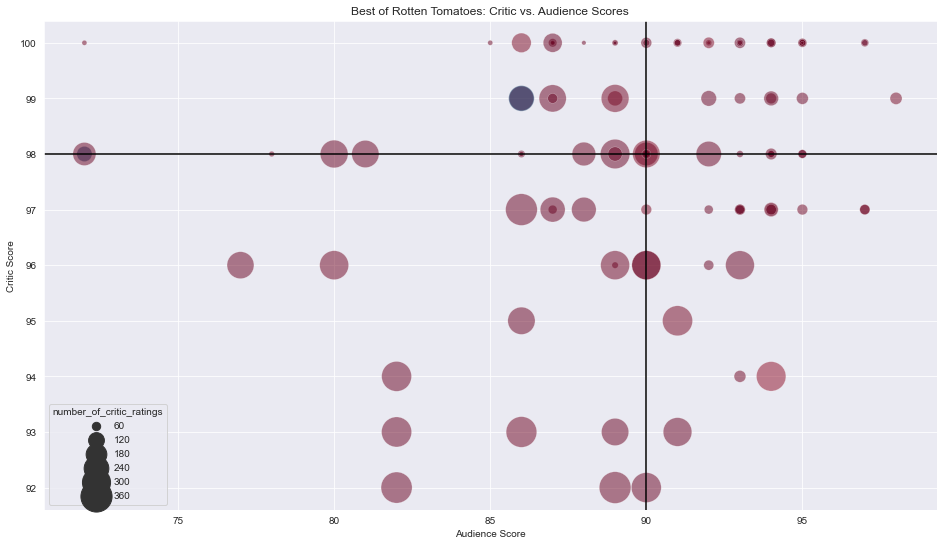

In [21]:
# set seaborn "whitegrid" theme
from turtle import color

# figure size
plt.figure(figsize=(16,9))

# use the scatterplot function
sns.scatterplot(data=merge_df, x="audience_score", y="critic_score", 
                size="number_of_critic_ratings", cmap='RdBu',
                c=merge_df.number_of_audience_ratings,
                edgecolors="black", alpha=0.5, sizes=(10, 1000))

# Add titles (main and on axis)
plt.xlabel("Audience Score")
plt.ylabel("Critic Score")
plt.title("Best of Rotten Tomatoes: Critic vs. Audience Scores")
plt.axvline(x=merge_df.audience_score.median(), color='black')
plt.axhline(y=merge_df.critic_score.median(), color='black')

# show the graph
plt.show()

There's still work to be done on the chart but I'll leave it for now to continue with the course. Below is what I'm trying to achieve.

![bubbleplot](img/visualization.png)

## Source: Downloading File from the Internet.
Here, we'll work a bit with HTTPS and Python's `request` library. We're trying to create a word cloud visualization for the Top 100 movies based of Dr Ebert's reviews so as to see what made the movie stand out. 

Unfortunately, we could only find 88 movie reviews off his site so we'll work with that number.

In [22]:
import requests
import os

In [23]:
# make directory if it doesn't already exist
folder_name = 'ebert_reviews'

if not os.path.exists(folder_name):
      os.makedirs(folder_name)

In [24]:
ebert_review_urls = ['https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9900_1-the-wizard-of-oz-1939-film/1-the-wizard-of-oz-1939-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9901_2-citizen-kane/2-citizen-kane.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9901_3-the-third-man/3-the-third-man.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9902_4-get-out-film/4-get-out-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9902_5-mad-max-fury-road/5-mad-max-fury-road.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9902_6-the-cabinet-of-dr.-caligari/6-the-cabinet-of-dr.-caligari.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9903_7-all-about-eve/7-all-about-eve.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9903_8-inside-out-2015-film/8-inside-out-2015-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9903_9-the-godfather/9-the-godfather.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_10-metropolis-1927-film/10-metropolis-1927-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_11-e.t.-the-extra-terrestrial/11-e.t.-the-extra-terrestrial.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_12-modern-times-film/12-modern-times-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9904_14-singin-in-the-rain/14-singin-in-the-rain.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9905_15-boyhood-film/15-boyhood-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9905_16-casablanca-film/16-casablanca-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9905_17-moonlight-2016-film/17-moonlight-2016-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9906_18-psycho-1960-film/18-psycho-1960-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9906_19-laura-1944-film/19-laura-1944-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9906_20-nosferatu/20-nosferatu.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9907_21-snow-white-and-the-seven-dwarfs-1937-film/21-snow-white-and-the-seven-dwarfs-1937-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9907_22-a-hard-day27s-night-film/22-a-hard-day27s-night-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9907_23-la-grande-illusion/23-la-grande-illusion.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9908_25-the-battle-of-algiers/25-the-battle-of-algiers.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9908_26-dunkirk-2017-film/26-dunkirk-2017-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9908_27-the-maltese-falcon-1941-film/27-the-maltese-falcon-1941-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9909_29-12-years-a-slave-film/29-12-years-a-slave-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9909_30-gravity-2013-film/30-gravity-2013-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9909_31-sunset-boulevard-film/31-sunset-boulevard-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990a_32-king-kong-1933-film/32-king-kong-1933-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990a_33-spotlight-film/33-spotlight-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990a_34-the-adventures-of-robin-hood/34-the-adventures-of-robin-hood.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990b_35-rashomon/35-rashomon.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990b_36-rear-window/36-rear-window.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990b_37-selma-film/37-selma-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990c_38-taxi-driver/38-taxi-driver.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990c_39-toy-story-3/39-toy-story-3.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990c_40-argo-2012-film/40-argo-2012-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_41-toy-story-2/41-toy-story-2.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_42-the-big-sick/42-the-big-sick.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_43-bride-of-frankenstein/43-bride-of-frankenstein.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990d_44-zootopia/44-zootopia.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990e_45-m-1931-film/45-m-1931-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990e_46-wonder-woman-2017-film/46-wonder-woman-2017-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990e_48-alien-film/48-alien-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990f_49-bicycle-thieves/49-bicycle-thieves.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990f_50-seven-samurai/50-seven-samurai.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad990f_51-the-treasure-of-the-sierra-madre-film/51-the-treasure-of-the-sierra-madre-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9910_52-up-2009-film/52-up-2009-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9910_53-12-angry-men-1957-film/53-12-angry-men-1957-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9910_54-the-400-blows/54-the-400-blows.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9911_55-logan-film/55-logan-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9911_57-army-of-shadows/57-army-of-shadows.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9912_58-arrival-film/58-arrival-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9912_59-baby-driver/59-baby-driver.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_60-a-streetcar-named-desire-1951-film/60-a-streetcar-named-desire-1951-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_61-the-night-of-the-hunter-film/61-the-night-of-the-hunter-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_62-star-wars-the-force-awakens/62-star-wars-the-force-awakens.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9913_63-manchester-by-the-sea-film/63-manchester-by-the-sea-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9914_64-dr.-strangelove/64-dr.-strangelove.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9914_66-vertigo-film/66-vertigo-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9914_67-the-dark-knight-film/67-the-dark-knight-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9915_68-touch-of-evil/68-touch-of-evil.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9915_69-the-babadook/69-the-babadook.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9915_72-rosemary27s-baby-film/72-rosemary27s-baby-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9916_73-finding-nemo/73-finding-nemo.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9916_74-brooklyn-film/74-brooklyn-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9917_75-the-wrestler-2008-film/75-the-wrestler-2008-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9917_77-l.a.-confidential-film/77-l.a.-confidential-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9918_78-gone-with-the-wind-film/78-gone-with-the-wind-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9918_79-the-good-the-bad-and-the-ugly/79-the-good-the-bad-and-the-ugly.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9918_80-skyfall/80-skyfall.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_82-tokyo-story/82-tokyo-story.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_83-hell-or-high-water-film/83-hell-or-high-water-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_84-pinocchio-1940-film/84-pinocchio-1940-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad9919_85-the-jungle-book-2016-film/85-the-jungle-book-2016-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991a_86-la-la-land-film/86-la-la-land-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991b_87-star-trek-film/87-star-trek-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991b_89-apocalypse-now/89-apocalypse-now.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991c_90-on-the-waterfront/90-on-the-waterfront.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991c_91-the-wages-of-fear/91-the-wages-of-fear.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991c_92-the-last-picture-show/92-the-last-picture-show.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991d_93-harry-potter-and-the-deathly-hallows-part-2/93-harry-potter-and-the-deathly-hallows-part-2.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991d_94-the-grapes-of-wrath-film/94-the-grapes-of-wrath-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991d_96-man-on-wire/96-man-on-wire.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_97-jaws-film/97-jaws-film.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_98-toy-story/98-toy-story.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_99-the-godfather-part-ii/99-the-godfather-part-ii.txt',
                     'https://d17h27t6h515a5.cloudfront.net/topher/2017/September/59ad991e_100-battleship-potemkin/100-battleship-potemkin.txt']

In [25]:
for url in ebert_review_urls:
      # creating the request
      response = requests.get(url)
      
      # accessing content and writing to a file
      with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
            file.write(response.content)

In [26]:
# confirming if our code worked.
assert len(ebert_review_urls) == len(os.listdir(folder_name))

Let's read the txt files into memory using `glob` and make a dataframe.

In [27]:
# import glob
import glob

In [28]:
# list of dictionaries to build file by file and later convert to df
reviews_list = []

# iterate through .txt files in 'ebert_reviews' folder
for ebert_review in glob.glob('ebert_reviews/*.txt'):  # * is a wildcard
      # encoding can be gotten by meta charset attribute of the HTML file
      with open(ebert_review, encoding='utf-8') as file:
            # let's get title, url and text
            title = file.readline()[:-1]
            review_url = file.readline()[:-1]
            review_text = file.read()
            #print(review_text); logging
            #break
            
            # append to list of dictionaries
            reviews_list.append({'title': title,
                                 'review_url': review_url,
                                 'review_text': review_text})

ebertReview_df = pd.DataFrame(reviews_list)            

In [29]:
ebertReview_df.head()

,title,review_url,review_text
0,The Wizard of Oz (1939),http://www.rogerebert.com/reviews/great-movie-...,As a child I simply did not notice whether a m...
1,Metropolis (1927),http://www.rogerebert.com/reviews/great-movie-...,The opening shots of the restored “Metropolis”...
2,Battleship Potemkin (1925),http://www.rogerebert.com/reviews/great-movie-...,"""The Battleship Potemkin” has been so famous f..."
3,E.T. The Extra-Terrestrial (1982),http://www.rogerebert.com/reviews/great-movie-...,Dear Raven and Emil:\n\nSunday we sat on the b...
4,Modern Times (1936),http://www.rogerebert.com/reviews/modern-times...,"A lot of movies are said to be timeless, but s..."


That's good next, we'll need each movie's poster as a stencil for the word cloud. Our options;

* Using Rotten tomatoes Api (which is what we should have used in the first place). This one requires an application for use, so it isn't practical;
* Using Beautiful Soup to scrape the url for the image and then downloading it. We'll, although it's a good idea, there's a better option;
* Using MediaWiki api to get the movie posters off Wikipedia. This is easier and far better.

The access library on Python for MediaWiki is `wptools`. Let's test it out!

In [30]:
# installing it
#! pip install wptools

In [31]:
# import library
import wptools

Testing with Mahatma Gandhi Wikipedia page

In [32]:
# https://en.wikipedia.org/wiki/Mahatma_Gandhi
page = wptools.page('Mahatma_Gandhi')

let's call `get()` on the page to automatically fetch extracts, images, infobox data and other metadata

In [33]:
page.get()

en.wikipedia.org (query) Mahatma_Gandhi
en.wikipedia.org (query) Mahatma Gandhi (&plcontinue=19379|0|Envi...
en.wikipedia.org (query) Mahatma Gandhi (&plcontinue=19379|0|Lact...
en.wikipedia.org (query) Mahatma Gandhi (&plcontinue=19379|0|Righ...
en.wikipedia.org (query) Mahatma Gandhi (&plcontinue=19379|0|Will...
en.wikipedia.org (parse) 19379
www.wikidata.org (wikidata) Q1001
www.wikidata.org (labels) Q194279|P3788|Q100778893|P2163|P7029|P8...
www.wikidata.org (labels) Q76611|P3987|P910|P10242|P570|P1309|P10...
www.wikidata.org (labels) P2924|P1273|P10069|P1017|P5905|Q5137|Q8...
www.wikidata.org (labels) P691|P1207|P271|P2607|P5008|P1576|P1938...
www.wikidata.org (labels) P69|Q9089|P22|Q46002746|P9178|P157|P21|...
www.wikidata.org (labels) P4839|Q142534|P1819|Q13382529|P9522|P43...
www.wikidata.org (labels) P7859|P1411|P2734|Q2353373|P6327|Q18316...
en.wikipedia.org (restbase) /page/summary/Mahatma_Gandhi
en.wikipedia.org (imageinfo) File:Mahatma-Gandhi, studio, 1931.jpg
Mahatma Gand

`page` now has the following attributes which can be accessed using dot notations through `.data`. For example `page.data['image']` would return a list of data for six images on this specific Wikipedia page.

In [34]:
page.data['image']

[{'kind': 'query-pageimage',
  'file': 'File:Mahatma-Gandhi, studio, 1931.jpg',
  'orig': 'Mahatma-Gandhi,_studio,_1931.jpg',
  'timestamp': '2019-02-26T13:14:24Z',
  'size': 3250029,
  'width': 2620,
  'height': 3270,
  'url': 'https://upload.wikimedia.org/wikipedia/commons/7/7a/Mahatma-Gandhi%2C_studio%2C_1931.jpg',
  'descriptionurl': 'https://commons.wikimedia.org/wiki/File:Mahatma-Gandhi,_studio,_1931.jpg',
  'descriptionshorturl': 'https://commons.wikimedia.org/w/index.php?curid=76882768',
  'title': 'File:Mahatma-Gandhi, studio, 1931.jpg',
  'metadata': {'DateTime': {'value': '2019-02-26 13:14:24',
    'source': 'mediawiki-metadata',
    'hidden': ''},
   'ObjectName': {'value': 'Mahatma-Gandhi, studio, 1931',
    'source': 'mediawiki-metadata',
    'hidden': ''},
   'CommonsMetadataExtension': {'value': 1.2,
    'source': 'extension',
    'hidden': ''},
   'Categories': {'value': 'Files uploaded by Yann Forget|Mohandas K. Gandhi in 1931|Mohandas K. Gandhi in England|PD-1996|PD-

The API returned data in JSON format which can be accessed in Python just like dictionaries and lists. So before, I download the movie poster images to add to the word cloud, let's get comfortable with accessing `wptools` page object attributes.

We'll inspect the wptools `page` object for the [E.T._the_Extra-Terrestrial](https://en.wikipedia.org/wiki/E.T._the_Extra-Terrestrial)'s Wikipedia page

In [35]:
page = wptools.page('E.T._the_Extra-Terrestrial').get()

en.wikipedia.org (query) E.T._the_Extra-Terrestrial
en.wikipedia.org (query) E.T. the Extra-Terrestrial (&plcontinue=...
en.wikipedia.org (parse) 73441
www.wikidata.org (wikidata) Q11621
www.wikidata.org (labels) Q281939|Q60629803|Q4376972|P2363|P840|Q...
www.wikidata.org (labels) P2334|Q505449|P3135|P227|P58|Q76757691|...
www.wikidata.org (labels) P214|P1258|Q787131|Q229009|Q8436|P3417|...
www.wikidata.org (labels) Q1131772|P4969|P8033|Q105708928|P5099|Q...
www.wikidata.org (labels) Q18665334|P1476|Q105640076|Q739633|P639...
en.wikipedia.org (restbase) /page/summary/E.T._the_Extra-Terrestrial
en.wikipedia.org (imageinfo) File:ET logo 3.svg|File:E t the extr...
E.T. the Extra-Terrestrial (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(2)> E.T., ET
  assessments: <dict(4)> United States, Film, Science Fiction, Lib...
  claims: <dict(129)> P1562, P57, P272, P345, P31, P161, P373, P48...
  description: 1982 American science fiction film
  exhtml: <str(461)> <p><i><b>E.T. the E

Accessing the first image in the images attribute, which is a JSON array.

In [36]:
page.data['image'][0]

{'kind': 'parse-image',
 'file': 'File:E t the extra terrestrial ver3.jpg',
 'orig': 'E t the extra terrestrial ver3.jpg',
 'timestamp': '2016-06-04T10:30:46Z',
 'size': 83073,
 'width': 253,
 'height': 394,
 'url': 'https://upload.wikimedia.org/wikipedia/en/6/66/E_t_the_extra_terrestrial_ver3.jpg',
 'descriptionurl': 'https://en.wikipedia.org/wiki/File:E_t_the_extra_terrestrial_ver3.jpg',
 'descriptionshorturl': 'https://en.wikipedia.org/w/index.php?curid=7419503',
 'title': 'File:E t the extra terrestrial ver3.jpg',
 'metadata': {'DateTime': {'value': '2016-06-04 10:30:46',
   'source': 'mediawiki-metadata',
   'hidden': ''},
  'ObjectName': {'value': 'E t the extra terrestrial ver3',
   'source': 'mediawiki-metadata',
   'hidden': ''},
  'CommonsMetadataExtension': {'value': 1.2,
   'source': 'extension',
   'hidden': ''},
  'Categories': {'value': 'All non-free media|E.T. the Extra-Terrestrial|Fair use images of film posters|Files with no machine-readable author|Noindexed pages|Wik

Accessing the director key of the infobox attribute, which is a JSON object

In [37]:
page.data['infobox'].get('director')

'[[Steven Spielberg]]'

Now, let's combine all that we've learnt to get our movie posters. Remember that for non-text requests like image, `PIL` library and `BytesIO` from `IO` library are recommended.

**Algorithm**
* Get a list 'title_list' which contains all the Wikipedia page titles for each movie in the Rotten Tomatoes Top 100 Movies of All Time list. It should be in the same order as the Top 100.
* Create an empty folder, `bestofrt_posters`, to store the downloaded movie poster image files.
* Create an empty list, `poster_list`, to which dictionaries will be appended.
* Create an empty dictionary, `image_errors`, to keep track of movie poster image URLs that don't work.
* Loop through the titles in `title_list` and:

      * Store the `ranking` of that movie based on it's position in `title_list`. 
        We'll need this when it's time to merge. We can merge on title because it 
        might differ.
      * Use `try` and `except` blocks to attempt to query MediaWiki for a movie poster 
        image URL and to attempt to download that image. If the attempt fails and an 
        error is encountered, the offending movie is documented in 'image_errors.
      * Appends a dictionary with `ranking`, `title`, and `poster_url` as the keys and 
        the extracted values for each as the values to `poster_list`
        
* Inspect the images that caused errors and download the correct image individually (either via another `url` in the `image` attribute's list or a url from Google Images).
* Create a DataFrame called `poster_df` from `poster_list` (a list of dicts.)


In [38]:
# import libraries
from PIL import Image
from io import BytesIO

In [40]:
title_list = [
 'The_Wizard_of_Oz_(1939_film)',
 'Citizen_Kane',
 'The_Third_Man',
 'Get_Out_(film)',
 'Mad_Max:_Fury_Road',
 'The_Cabinet_of_Dr._Caligari',
 'All_About_Eve',
 'Inside_Out_(2015_film)',
 'The_Godfather',
 'Metropolis_(1927_film)',
 'E.T._the_Extra-Terrestrial',
 'Modern_Times_(film)',
 'It_Happened_One_Night',
 "Singin'_in_the_Rain",
 'Boyhood_(film)',
 'Casablanca_(film)',
 'Moonlight_(2016_film)',
 'Psycho_(1960_film)',
 'Laura_(1944_film)',
 'Nosferatu',
 'Snow_White_and_the_Seven_Dwarfs_(1937_film)',
 "A_Hard_Day%27s_Night_(film)",
 'La_Grande_Illusion',
 'North_by_Northwest',
 'The_Battle_of_Algiers',
 'Dunkirk_(2017_film)',
 'The_Maltese_Falcon_(1941_film)',
 'Repulsion_(film)',
 '12_Years_a_Slave_(film)',
 'Gravity_(2013_film)',
 'Sunset_Boulevard_(film)',
 'King_Kong_(1933_film)',
 'Spotlight_(film)',
 'The_Adventures_of_Robin_Hood',
 'Rashomon',
 'Rear_Window',
 'Selma_(film)',
 'Taxi_Driver',
 'Toy_Story_3',
 'Argo_(2012_film)',
 'Toy_Story_2',
 'The_Big_Sick',
 'Bride_of_Frankenstein',
 'Zootopia',
 'M_(1931_film)',
 'Wonder_Woman_(2017_film)',
 'The_Philadelphia_Story_(film)',
 'Alien_(film)',
 'Bicycle_Thieves',
 'Seven_Samurai',
 'The_Treasure_of_the_Sierra_Madre_(film)',
 'Up_(2009_film)',
 '12_Angry_Men_(1957_film)',
 'The_400_Blows',
 'Logan_(film)',
 'All_Quiet_on_the_Western_Front_(1930_film)',
 'Army_of_Shadows',
 'Arrival_(film)',
 'Baby_Driver',
 'A_Streetcar_Named_Desire_(1951_film)',
 'The_Night_of_the_Hunter_(film)',
 'Star_Wars:_The_Force_Awakens',
 'Manchester_by_the_Sea_(film)',
 'Dr._Strangelove',
 'Frankenstein_(1931_film)',
 'Vertigo_(film)',
 'The_Dark_Knight_(film)',
 'Touch_of_Evil',
 'The_Babadook',
 'The_Conformist_(film)',
 'Rebecca_(1940_film)',
 "Rosemary%27s_Baby_(film)",
 'Finding_Nemo',
 'Brooklyn_(film)',
 'The_Wrestler_(2008_film)',
 'The_39_Steps_(1935_film)',
 'L.A._Confidential_(film)',
 'Gone_with_the_Wind_(film)',
 'The_Good,_the_Bad_and_the_Ugly',
 'Skyfall',
 'Rome,_Open_City',
 'Tokyo_Story',
 'Hell_or_High_Water_(film)',
 'Pinocchio_(1940_film)',
 'The_Jungle_Book_(2016_film)',
 'La_La_Land_(film)',
 'Star_Trek_(film)',
 'High_Noon',
 'Apocalypse_Now',
 'On_the_Waterfront',
 'The_Wages_of_Fear',
 'The_Last_Picture_Show',
 'Harry_Potter_and_the_Deathly_Hallows_–_Part_2',
 'The_Grapes_of_Wrath_(film)',
 'Roman_Holiday',
 'Man_on_Wire',
 'Jaws_(film)',
 'Toy_Story',
 'The_Godfather_Part_II',
 'Battleship_Potemkin'
]

In [41]:
# create an empty folder to store posters
folder_name = 'bestofrt_posters'

# check if it exists before creation
if not os.path.exists(folder_name):
      os.makedirs(folder_name)

In [42]:
poster_list = []
image_errors = {}

# iterate through title_list
for title in title_list:
      try:
            # getting rank from (position + 1) of the title in title_list
            ranking = title_list.index(title) + 1
            print(ranking) # to guage time remaining because this cell is slow
            # get the page's attributes off the api using the access library
            page = wptools.page(title, silent=True)
            # let's get the url from the 1st image attribute
            images = page.get().data['image']
            first_image_url = images[0]['url']
            # request for image from url. Response in bytes
            # I kept getting HTTP 403 error so I had to get my user-agent to resolve it
            header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36"}
            r = requests.get(first_image_url,
                             headers = header)
            # download and save movie poster
            i = Image.open(BytesIO(r.content))
            # get image format
            image_file_format = first_image_url.split('.')[-1]
            # save at, e.g. 'bestofrt_poster/98_Toy_Story.jpg'
            i.save(folder_name + "/" + str(ranking) + '_' + title + '.' + image_file_format)
            # append relevant info to list of dictionaries
            poster_list.append({'ranking': int(ranking),
                                'title': title,
                                'poster_url': first_image_url})
      # not best practice to catch all exceptions but I can use this now
      except Exception as e:
            print(str(ranking) + "_" + title + ": " + str(e))
            image_errors[str(ranking) + '_' + title] = images

1
2
3
4
5
6
7
8
9
10
10_Metropolis_(1927_film): cannot identify image file <_io.BytesIO object at 0x000002A815AF5400>
11
12
13
14
15
15_Boyhood_(film): 'image'
16
17
18
19
20
21
22


API error: {'code': 'invalidtitle', 'info': 'Bad title "A_Hard_Day%27s_Night_(film)".', 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


22_A_Hard_Day%27s_Night_(film): https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=A_Hard_Day%2527s_Night_%28film%29
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


API error: {'code': 'invalidtitle', 'info': 'Bad title "Rosemary%27s_Baby_(film)".', 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


72_Rosemary%27s_Baby_(film): https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Rosemary%2527s_Baby_%28film%29
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Here is the list of movies that their posters didn't download. Let's look at a few of them.

In [43]:
image_errors.keys()

dict_keys(['10_Metropolis_(1927_film)', '15_Boyhood_(film)', '22_A_Hard_Day%27s_Night_(film)', '72_Rosemary%27s_Baby_(film)'])

Let's redownload these ones. 

I notice that the url that was provided to them at `images` when they were stored in `image_errors` was the url of the previous image because the code hit an error due to the page not being found on Wikipedia.

Changes to impliment:

* Change Boyhood title to 'Boyhood_(2014_film)'
* Provide image links for titles with '%'
* For Metropolis, used the 5th dictionary instead of the first `page.get().data['image'][4]['url']`
* 'Mad_Max:_Fury_Road' didn't download properly so redownload.
* 'Star_Wars:_The_Force_Awakens' needs to be redownloaded.

In [96]:
# change Boyhood title
if image_errors['15_Boyhood_(film)']:
      image_errors['15_Boyhood_(2014_film)'] = image_errors['15_Boyhood_(film)']
      del image_errors['15_Boyhood_(film)']

In [199]:
len(poster_list)

101

In [200]:
# del old Boyhood title from poster_list
idx = 0
for poster in poster_list:
      if poster['title'] == 'Boyhood_(film)':
            del poster_list[idx]
      idx += 1

In [201]:
len(poster_list)

100

In [106]:
# get list of image_errors.keys()
errorList = list(image_errors.keys())

In [113]:
# add movies that are in poster_list but with errors into errorList
for i in ['5_Mad_Max:_Fury_Road', '62_Star_Wars:_The_Force_Awakens']:
      errorList.append(i)

In [123]:
errorList

['10_Metropolis_(1927_film)',
 '22_A_Hard_Day%27s_Night_(film)',
 '72_Rosemary%27s_Baby_(film)',
 '15_Boyhood_(2014_film)',
 '5_Mad_Max:_Fury_Road',
 '62_Star_Wars:_The_Force_Awakens']

In [169]:
# deleting initial record from poster_list

for error in errorList:
      for i in range(len(poster_list)):
            if poster_list[i]['title'] in error:
                  del poster_list[i]

In [183]:
# iterate through list
eList = []
for error in errorList:
      try:
            # split out the ranking and title from key
            splitList = error.split('_')
            ranking = splitList[0]
            title = '_'.join(splitList[1:])
            
            # getting url for poster img
            if error == '22_A_Hard_Day%27s_Night_(film)':
                  wikiUrl = 'https://upload.wikimedia.org/wikipedia/en/4/47/A_Hard_Days_night_movieposter.jpg'
            elif error == '72_Rosemary%27s_Baby_(film)':
                  wikiUrl = 'https://upload.wikimedia.org/wikipedia/en/e/ef/Rosemarys_baby_poster.jpg'
            elif error == '10_Metropolis_(1927_film)':
                  page = wptools.page(title, silent=True)
                  images = page.get().data['image']
                  wikiUrl = images[4]['url']
            else:
                  page = wptools.page(title, silent=True)
                  images = page.get().data['image']
                  wikiUrl = images[0]['url']
            # request for image
            r = requests.get(wikiUrl, headers=header)
            # logging
            if r.ok:
                  print("Success: ", title)
            i = Image.open(BytesIO(r.content))
            # get image format
            image_file_format = wikiUrl.split('.')[-1]
            # save to folder
            i.save(folder_name + "/" + ranking + '_' + title.replace(':','') + '.' + image_file_format)
            print('saved') # log
            # append to list
            #poster_list.append({'ranking': int(ranking),
            #                    'title': title,
            #                    'poster_url': first_image_url})
      except Exception as e:
            print("{}: Error!".format(title), e)
            eList.append(i)


Success:  Metropolis_(1927_film)
saved
Success:  A_Hard_Day%27s_Night_(film)
saved
Success:  Rosemary%27s_Baby_(film)
saved
Success:  Boyhood_(2014_film)
saved
Success:  Mad_Max:_Fury_Road
saved
Success:  Star_Wars:_The_Force_Awakens
saved


In [202]:
# create Dataframe from list of dictionaries
poster_df = pd.DataFrame(poster_list)
poster_df = poster_df.sort_values('ranking').reset_index(drop=True)
poster_df

,ranking,title,poster_url
0,1,The_Wizard_of_Oz_(1939_film),https://upload.wikimedia.org/wikipedia/commons...
1,2,Citizen_Kane,https://upload.wikimedia.org/wikipedia/commons...
2,3,The_Third_Man,https://upload.wikimedia.org/wikipedia/commons...
3,4,Get_Out_(film),https://upload.wikimedia.org/wikipedia/en/a/a3...
4,5,Mad_Max:_Fury_Road,https://upload.wikimedia.org/wikipedia/commons...
...,...,...,...
95,96,Man_on_Wire,https://upload.wikimedia.org/wikipedia/en/5/54...
96,97,Jaws_(film),https://upload.wikimedia.org/wikipedia/en/e/eb...
97,98,Toy_Story,https://upload.wikimedia.org/wikipedia/en/1/13...
98,99,The_Godfather_Part_II,https://upload.wikimedia.org/wikipedia/en/0/03...


Since the lesson isn't on Data Viz, this is the expected Word cloud


![wordcloud](img/wordclouds.jpg)

## Storing Data in Relational Databases
Let's save our dataframes locally to .csv

In [216]:
merge_df.to_csv('merge_df.csv', index=False)
ebertReview_df.to_csv('ebertReview_df.tsv', sep='\t',index=False)
poster_df.to_csv('poster_df.csv', index=False)

### 1. Connect to a database

In [207]:
! pip install sqlalchemy

In [217]:
from sqlalchemy import create_engine

In [218]:
# Create SQLAlchemy Engine and empty bestofrt database

engine = create_engine('sqlite:///bestofrt.db')

### 2. Store pandas DataFrame in database
Store the data in the cleaned dataset in that database

In [ ]:
# Store cleaned DataFrame in a table called master in bestofrt.db
merge_df.to_sql('merge_df', engine, index=False)
ebertReview_df.to_sql('ebertReview_df', engine, index=False)
poster_df.to_sql('poster_df', engine, index=False)

### 3. Read database data into a pandas DataFrame
Read the brand new data in that database back into a pandas DataFrame.

In [221]:
df_gather = pd.read_sql('SELECT * FROM merge_df', engine)

In [222]:
df_gather.head()

,ranking,critic_score,title,number_of_critic_ratings,audience_score,number_of_audience_ratings
0,1,99,The Wizard of Oz (1939),110,89,874425
1,2,100,Citizen Kane (1941),75,90,157274
2,3,100,The Third Man (1949),77,93,53081
3,4,99,Get Out (2017),282,87,63837
4,5,97,Mad Max: Fury Road (2015),370,86,123937


The end......or is it?